## Example 1: Spin-Bath model, fitting of spectrum and correlation functions
### Introduction

The HEOM method solves the dynamics and steady state of a system and its environment, the latter of which is encoded in a set of auxiliary density matrices.

In this example we show the evolution of a single two-level system in contact with a single Bosonic environment.  The properties of the system are encoded in Hamiltonian, and a coupling operator which describes how it is coupled to the environment.

The Bosonic environment is implicitly assumed to obey a particular Hamiltonian (see paper), the parameters of which are encoded in the spectral density, and subsequently the free-bath correlation functions.

In the example below we show how model an Ohmic environment with exponential cut-off in two ways. First we fit the spectrum with a set of underdamped brownian oscillator functions. Second, we evaluate the correlation functions, and fit those with a certain choice of exponential functions.  



In [1]:
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [2]:
from qutip import *

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:

from bofinpy.heom import BosonicHEOMSolver

In [7]:

def cot(x):
    return 1./np.tan(x)


In [8]:
# Defining the system Hamiltonian
eps = .0    # Energy of the 2-level system.
Del = .2    # Tunnelling term
Hsys = 0.5 * eps * sigmaz() + 0.5 * Del* sigmax()

In [9]:
# Initial state of the system.
rho0 = basis(2,0) * basis(2,0).dag()  

In [10]:
#Import mpmath functions for evaluation of correlation functions

from mpmath import mp
from mpmath import zeta
from mpmath import gamma

mp.dps = 15; mp.pretty = True

In [11]:

Q = sigmaz()

alpha = 3.25
T = 0.5

wc = 1
beta  = 1/T 
s = 1


tlist = np.linspace(0, 10, 5000)
tlist3 = linspace(0,15,50000)


#note: the arguments to zeta should be in as high precision as possible, might need some adjustment
# see http://mpmath.org/doc/current/basics.html#providing-correct-input
ct = [complex((1/pi)*alpha * wc**(1-s) * beta**(-(s+1)) * (zeta(s+1,(1+beta*wc-1.0j*wc*t)/(beta*wc)) + 
            zeta(s+1,(1+1.0j*wc*t)/(beta*wc)))) for t in tlist]


#also check long timescales
ctlong = [complex((1/pi)*alpha * wc**(1-s) * beta**(-(s+1)) * (zeta(s+1,(1+beta*wc-1.0j*wc*t)/(beta*wc)) + 
            zeta(s+1,(1+1.0j*wc*t)/(beta*wc)))) for t in tlist3]


corrRana =  real(ctlong)
corrIana = imag(ctlong)


pref = 1.



1
2
3
4
[6.14746382 1.77939431 0.1       ]


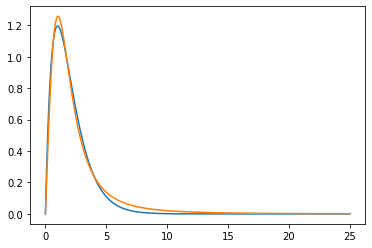

[2.2118604  3.2625202  1.24955211 1.43449493 0.1        1.80554081]


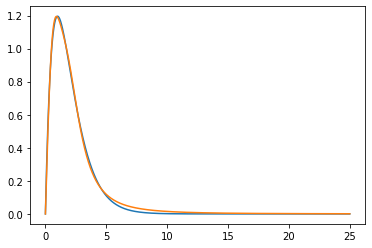

[1.65042459 1.12652912 2.33974636 1.18469437 1.00828623 1.09355394
 2.69755852 0.13430903 1.37013075]


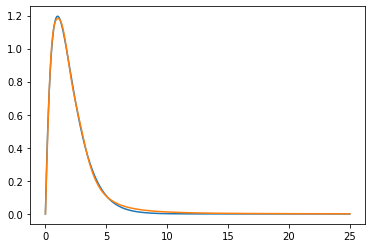

[ 0.60083695  7.91592682 -4.4078923   0.01058513  1.00246794  2.29618991
  4.2990816   0.30736316  0.1         0.1         3.98168676  0.1       ]


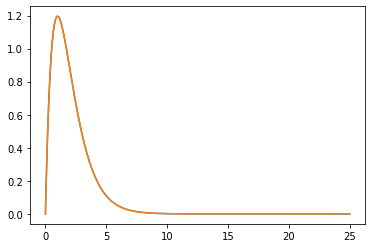

In [12]:

#lets try fitting the spectrurum
#use underdamped case with meier tannor form 


wlist = np.linspace(0, 25, 20000)

from scipy.optimize import curve_fit

#seperate functions for plotting later:



def fit_func_nocost(x, a, b, c, N):
    tot = 0
    for i in range(N):
        
        tot+= 2 * a[i] * b[i] * (x)/(((x+c[i])**2 + (b[i]**2))*((x-c[i])**2 + (b[i]**2)))
    cost = 0.
    
    return tot   

def wrapper_fit_func_nocost(x, N, *args):
    a, b, c = list(args[0][:N]), list(args[0][N:2*N]),list(args[0][2*N:3*N])
    # print("debug")
    return fit_func_nocost(x, a, b, c, N)


# function that evaluates values with fitted params at
# given inputs
def checker(tlist, vals, N):
    y = []
    for i in tlist:
        # print(i)
        
        y.append(wrapper_fit_func_nocost(i, N, vals))
    return y


#######
#Real part 

def wrapper_fit_func(x, N, *args):
    a, b, c = list(args[0][:N]), list(args[0][N:2*N]),list(args[0][2*N:3*N])
    # print("debug")
    return fit_func(x, a, b, c, N)



def fit_func(x, a, b, c,  N):
    tot = 0
    for i in range(N):
        
        tot+= 2 * a[i] * b[i] * (x)/(((x+c[i])**2 + (b[i]**2))*((x-c[i])**2 + (b[i]**2)))
    cost = 0.
    #for i in range(N):
        #print(i)
    #    cost += ((corrRana[0]-a[i]*np.cos(d[i])))
        
        
    tot+=0.0*cost
    
    return tot      

def fitterR(ans, tlist, k):
    # the actual computing of fit
    popt = []
    pcov = [] 
    # tries to fit for k exponents
    for i in range(k):
        #params_0 = [0]*(2*(i+1))
        params_0 = [0.]*(3*(i+1))
        upper_a = 100*abs(max(ans, key = abs))
        #sets initial guess
        guess = []
        #aguess = [ans[0]]*(i+1)#[max(ans)]*(i+1)
        aguess = [abs(max(ans, key = abs))]*(i+1)
        bguess = [1*wc]*(i+1)
        cguess = [1*wc]*(i+1)
        
        guess.extend(aguess)
        guess.extend(bguess)
        guess.extend(cguess)
       
        # sets bounds
        # a's = anything , b's negative
        # sets lower bound
        b_lower = []
        alower = [-upper_a]*(i+1)
        blower = [0.1*wc]*(i+1)
        clower = [0.1*wc]*(i+1)
        
        b_lower.extend(alower)
        b_lower.extend(blower)
        b_lower.extend(clower)
        
        # sets higher bound
        b_higher = []
        ahigher = [upper_a]*(i+1)
        #bhigher = [np.inf]*(i+1)
        bhigher = [100*wc]*(i+1)
        chigher = [100*wc]*(i+1)
      
        b_higher.extend(ahigher)
        b_higher.extend(bhigher)
        b_higher.extend(chigher)
       
        param_bounds = (b_lower, b_higher)
        
        p1, p2 = curve_fit(lambda x, *params_0: wrapper_fit_func(x, i+1, \
            params_0), tlist, ans, p0=guess, bounds = param_bounds,sigma=[0.0001 for w in wlist], maxfev = 1000000000)
        popt.append(p1)
        pcov.append(p2)
        print(i+1)
    return popt
# print(popt)


J = [w * alpha * e**(-w/wc)  for w in wlist]
k = 4
popt1 = fitterR(J, wlist, k)
for i in range(k):
    y = checker(wlist, popt1[i],i+1)
    print(popt1[i])
    plt.plot(wlist, J, wlist, y)
    
    plt.show()
  


In [13]:


lam = list(popt1[k-1])[:k]

gamma = list(popt1[k-1])[k:2*k] #damping terms

w0 = list(popt1[k-1])[2*k:3*k] #w0 termss




print(lam)
print(gamma)
print(w0)

[0.6008369503697316, 7.915926817007419, -4.407892303394139, 0.010585134521710608]
[1.0024679415911746, 2.2961899070634466, 4.299081604528803, 0.3073631615421664]
[0.10000000000000006, 0.10000000000438339, 3.9816867612888034, 0.10000000000000002]


[0.6008369503697316, 7.915926817007419, -4.407892303394139, 0.010585134521710608]
[1.0024679415911746, 2.2961899070634466, 4.299081604528803, 0.3073631615421664]
[0.10000000000000006, 0.10000000000438339, 3.9816867612888034, 0.10000000000000002]


3.3300520631238443e-12


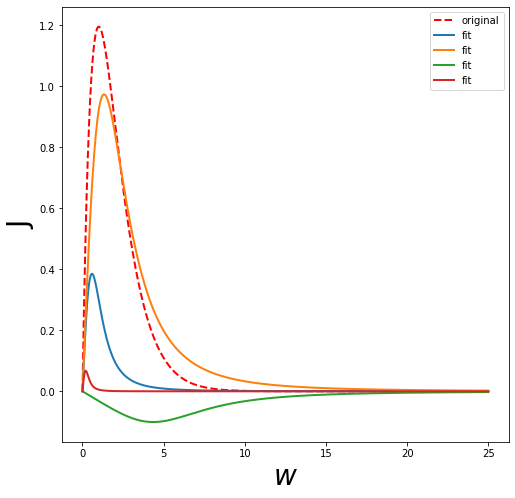

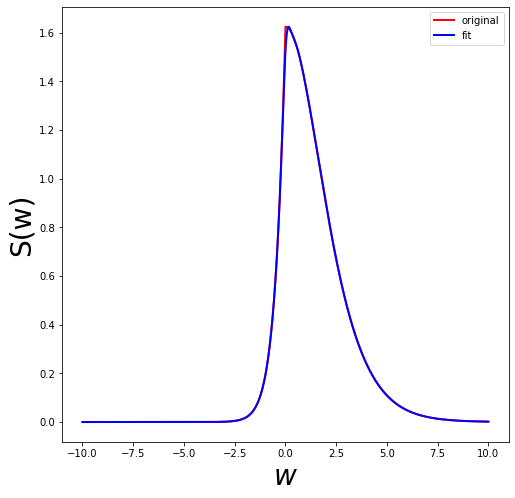

In [14]:

lamT = []

print(lam)
print(gamma)
print(w0)

fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))
axes.plot(wlist, J, 'r--', linewidth=2, label="original")
for kk,ll in enumerate(lam):
    #axes.plot(wlist,  [lam[kk] * gamma[kk] * (w)/(((w**2-w0[kk]**2)**2 + (gamma[kk]**2*w**2))) for w in wlist],linewidth=2)
    axes.plot(wlist,  [2* lam[kk] * gamma[kk] * (w)/(((w+w0[kk])**2 + (gamma[kk]**2))*((w-w0[kk])**2 + (gamma[kk]**2))) for w in wlist],linewidth=2, label="fit")





axes.set_xlabel(r'$w$', fontsize=28)
axes.set_ylabel(r'J', fontsize=28)

axes.legend()
fig.savefig('noisepower.eps')
wlist2 = np.linspace(-10,10 , 50000)



s1 =  [w * alpha * e**(-abs(w)/wc) *  ((1/(e**(w/T)-1))+1) for w in wlist2]
s2 = [sum([(2* lam[kk] * gamma[kk] * (w)/(((w+w0[kk])**2 + (gamma[kk]**2))*((w-w0[kk])**2 + (gamma[kk]**2)))) * ((1/(e**(w/T)-1))+1)  for kk,lamkk in enumerate(lam)]) for w in wlist2]


fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))
axes.plot(wlist2, s1, 'r', linewidth=2,label="original")
axes.plot(wlist2, s2, 'b', linewidth=2,label="fit")

axes.set_xlabel(r'$w$', fontsize=28)
axes.set_ylabel(r'S(w)', fontsize=28)

#axes.axvline(x=Del)
print(min(s2))
axes.legend()

#fig.savefig('powerspectrum.eps')
#J(w>0) * (n(w>w)+1)


In [15]:
def cot(x):
    return 1./np.tan(x)


def coth(x):
    """
    Calculates the coth function.
    
    Parameters
    ----------
    x: np.ndarray
        Any numpy array or list like input.
        
    Returns
    -------
    cothx: ndarray
        The coth function applied to the input.
    """
    return 1/np.tanh(x)

In [16]:

#underdamped meier tannior version with terminator


TermMax = 1000
TermOps = 0.*spre(sigmaz())
Nk = 1 # number of exponentials in approximation of the Matsubara approximation

pref = 1

ckAR = []
vkAR = []
ckAI = []
vkAI = []
for kk, ll in enumerate(lam):
    #print(kk)
    lamt = lam[kk]
    Om = w0[kk]
    Gamma = gamma[kk]
    print(T)
    print(coth(beta*(Om+1.0j*Gamma)/2))
    ckAR_temp = [(lamt/(4*Om))*coth(beta*(Om+1.0j*Gamma)/2),(lamt/(4*Om))*coth(beta*(Om-1.0j*Gamma)/2)]
    for k in range(1,Nk+1):
        #print(k)
        ek = 2*pi*k/beta
        ckAR_temp.append((-2*lamt*2*Gamma/beta)*ek/(((Om+1.0j*Gamma)**2+ek**2)*((Om-1.0j*Gamma)**2+ek**2)))
    
    
    
    term = 0
    for k in range(Nk+1,TermMax):
        #print(k)
        ek = 2*pi*k/beta
        ck = ((-2*lamt*2*Gamma/beta)*ek/(((Om+1.0j*Gamma)**2+ek**2)*((Om-1.0j*Gamma)**2+ek**2)))
        term += ck/ek
    ckAR.extend(ckAR_temp)
    
    vkAR_temp =   [-1.0j*Om+Gamma,1.0j*Om+Gamma]
    vkAR_temp.extend([2 * np.pi * k * T + 0.j for k in range(1,Nk+1)])
    
    vkAR.extend(vkAR_temp)
    factor=1./4.
    ckAI.extend([-factor*lamt*1.0j/(Om),factor*lamt*1.0j/(Om)])

    vkAI.extend( [-(-1.0j*(Om) - Gamma),-(1.0j*(Om) - Gamma)])
    
    TermOps += term * (2*spre(Q)*spost(Q.dag()) - spre(Q.dag()*Q) - spost(Q.dag()*Q))

print(ckAR)
print(vkAR)

Q2 = []

NR = len(ckAR)
NI = len(ckAI)

Q2.extend([ sigmaz() for kk in range(NR)])
Q2.extend([ sigmaz() for kk in range(NI)])
options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)

0.5
(0.13974905603792642-0.6297177694569625j)
0.5
(0.17664336822136417+0.8710457413222802j)
0.5
(0.9995285614798401-0.0005117323884516758j)
0.5
(0.9911416907546049-2.839164703402045j)
[(0.20991599161719096-0.9458942604853771j), (0.20991599161719096+0.9458942604853771j), (-0.04802658527749514+0j), (3.4957399387218+17.23783585567726j), (3.4957399387218-17.23783585567726j), (-5.327668329180397+0j), (-0.27662988811703487+0.00014162724190058603j), (-0.27662988811703487-0.00014162724190058603j), (0.09723731527324064+0j), (0.026228420316782967-0.0751323507870081j), (0.026228420316782967+0.0751323507870081j), (-0.00021348999257700898+0j)]
[(1.0024679415911746-0.10000000000000006j), (1.0024679415911746+0.10000000000000006j), (3.141592653589793+0j), (2.2961899070634466-0.10000000000438339j), (2.2961899070634466+0.10000000000438339j), (3.141592653589793+0j), (4.299081604528803-3.9816867612888034j), (4.299081604528803+3.9816867612888034j), (3.141592653589793+0j), (0.3073631615421664-0.100000000000

In [17]:
#corrRana =  real(ct)
#corrIana = imag(ct)
corrRana =  real(ctlong)
corrIana = imag(ctlong)

def checker2(tlisttemp):
    y = []
    for i in tlisttemp:
        # print(i)
        
        temp = []
        for kkk,ck in enumerate(ckAR):
            
            temp.append(ck*exp(-vkAR[kkk]*i))
            
        y.append(sum(temp))
    return y


yR = checker2(tlist3)



# function that evaluates values with fitted params at
# given inputs
def checker2(tlisttemp):
    y = []
    for i in tlisttemp:
        # print(i)
        
        temp = []
        for kkk,ck in enumerate(ckAI):
            if i==0: 
                print(vkAI[kkk])
            temp.append(ck*exp(-vkAI[kkk]*i))
            
        y.append(sum(temp))
    return y



yI = checker2(tlist3)



(1.0024679415911746+0.10000000000000006j)
(1.0024679415911746-0.10000000000000006j)
(2.2961899070634466+0.10000000000438339j)
(2.2961899070634466-0.10000000000438339j)
(4.299081604528803+3.9816867612888034j)
(4.299081604528803-3.9816867612888034j)
(0.3073631615421664+0.10000000000000002j)
(0.3073631615421664-0.10000000000000002j)


In [23]:
matplotlib.rcParams['figure.figsize'] = (7, 5)
matplotlib.rcParams['axes.titlesize'] = 25
matplotlib.rcParams['axes.labelsize'] = 30
matplotlib.rcParams['xtick.labelsize'] = 28
matplotlib.rcParams['ytick.labelsize'] = 28
matplotlib.rcParams['legend.fontsize'] = 20
matplotlib.rcParams['axes.grid'] = False
matplotlib.rcParams['savefig.bbox'] = 'tight'
matplotlib.rcParams['lines.markersize'] = 5
matplotlib.rcParams['font.family'] = 'STIXgeneral' 
matplotlib.rcParams['mathtext.fontset'] =  'stix'
matplotlib.rcParams["font.serif"] = "STIX"
matplotlib.rcParams['text.usetex'] = False

/home/neill/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


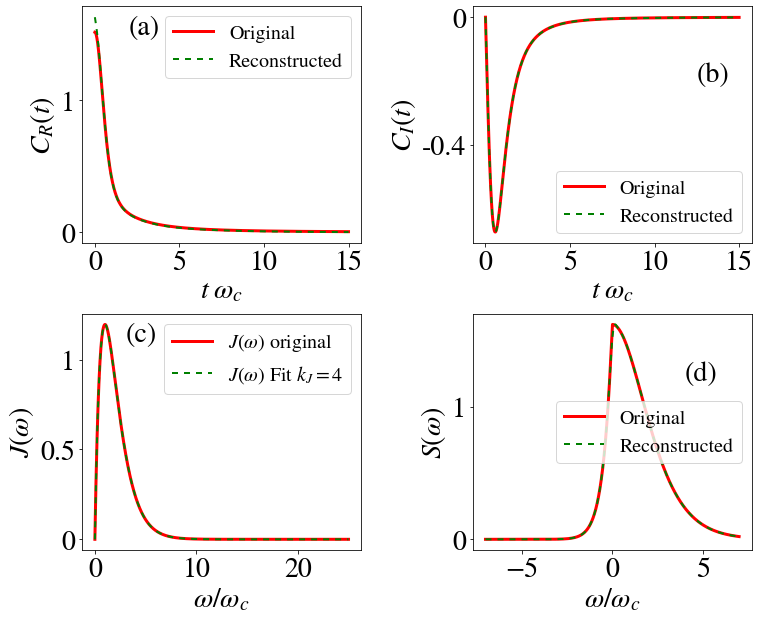

In [40]:
tlist2 = tlist3
from cycler import cycler

wlist2 = np.linspace(-2*pi*4,2 * pi *4 , 50000)
wlist2 = np.linspace(-7,7 , 50000)




fig = plt.figure(figsize=(12,10))
grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.3)

default_cycler = (cycler(color=['r', 'g', 'b', 'y','c','m','k']) +
                  cycler(linestyle=['-', '--', ':', '-.',(0, (1, 10)), (0, (5, 10)),(0, (3, 10, 1, 10))]))
plt.rc('axes',prop_cycle=default_cycler )


axes1 = fig.add_subplot(grid[0,0])
axes1.set_yticks([0.,1.])
axes1.set_yticklabels([0,1]) 
axes1.plot(tlist2, corrRana,"r",linewidth=3,label="Original")
axes1.plot(tlist2, yR,"g",dashes=[3,3],linewidth=2,label="Reconstructed")
axes1.legend(loc=0)

axes1.set_ylabel(r'$C_R(t)$',fontsize=28)

axes1.set_xlabel(r'$t\;\omega_c$',fontsize=28)
axes1.locator_params(axis='y', nbins=4)
axes1.locator_params(axis='x', nbins=4)
axes1.text(2.,1.5,"(a)",fontsize=28)


axes2 = fig.add_subplot(grid[0,1])
axes2.set_yticks([0.,-0.4])
axes2.set_yticklabels([0,-0.4])

axes2.plot(tlist2, corrIana,"r",linewidth=3,label="Original")
axes2.plot(tlist2, yI,"g",dashes=[3,3], linewidth=2,label="Reconstructed")
axes2.legend(loc=0)

axes2.set_ylabel(r'$C_I(t)$',fontsize=28)

axes2.set_xlabel(r'$t\;\omega_c$',fontsize=28)
axes2.locator_params(axis='y', nbins=4)
axes2.locator_params(axis='x', nbins=4)


axes2.text(12.5,-0.2,"(b)",fontsize=28)


axes3 = fig.add_subplot(grid[1,0])


axes3.set_yticks([0.,.5,1])
axes3.set_yticklabels([0,0.5,1])

axes3.plot(wlist, J,  "r",linewidth=3,label="$J(\omega)$ original")
y = checker(wlist, popt1[3],4)
axes3.plot(wlist,  y,  "g", dashes=[3,3], linewidth=2, label="$J(\omega)$ Fit $k_J = 4$")

axes3.set_ylabel(r'$J(\omega)$',fontsize=28)

axes3.set_xlabel(r'$\omega/\omega_c$',fontsize=28)
axes3.locator_params(axis='y', nbins=4)
axes3.locator_params(axis='x', nbins=4)
axes3.legend(loc=0)
axes3.text(3,1.1,"(c)",fontsize=28)


s1 =  [w * alpha * e**(-abs(w)/wc) *  ((1/(e**(w/T)-1))+1) for w in wlist2]
s2 = [sum([(2* lam[kk] * gamma[kk] * (w)/(((w+w0[kk])**2 + (gamma[kk]**2))*((w-w0[kk])**2 + (gamma[kk]**2)))) * ((1/(e**(w/T)-1))+1)  for kk,lamkk in enumerate(lam)]) for w in wlist2]


axes4 = fig.add_subplot(grid[1,1])



axes4.set_yticks([0.,1])
axes4.set_yticklabels([0,1])
axes4.plot(wlist2, s1,"r",linewidth=3,label="Original")
axes4.plot(wlist2, s2, "g", dashes=[3,3], linewidth=2,label="Reconstructed")

axes4.set_xlabel(r'$\omega/\omega_c$', fontsize=28)
axes4.set_ylabel(r'$S(\omega)$', fontsize=28)
axes4.locator_params(axis='y', nbins=4)
axes4.locator_params(axis='x', nbins=4)
axes4.legend()
axes4.text(4.,1.2,"(d)",fontsize=28)

fig.savefig("figFiJspec.pdf")


In [41]:



NC = 11


NR = len(ckAR)
NI = len(ckAI)
print(NR)
print(NI)
Q2 = []
Q2.extend([ sigmaz() for kk in range(NR)])
Q2.extend([ sigmaz() for kk in range(NI)])



12
8


In [42]:

#Q2 = [Q for kk in range(NR+NI)]
#print(Q2)

options = Options(nsteps=1500, store_states=True, rtol=1e-12, atol=1e-12, method="bdf") 
import time 

start = time.time()
print("start")


Ltot = liouvillian(Hsys) + TermOps


HEOMFit = BosonicHEOMSolver(Ltot, Q2, ckAR, ckAI, vkAR, vkAI, NC, options=options)

print("end")
end = time.time()
print(end - start)

start


/mnt/d/github/qutip-heom/heom_fmotd.py:224: UserWarning: Expected simplified input.
  warnings.warn("Expected simplified input.")


end
444.4286026954651


In [43]:
#tlist4 = np.linspace(0, 50, 1000)

tlist4 = np.linspace(0, 4*pi/Del, 600)
tlist4 = np.linspace(0, 30*pi/Del, 600)

rho0 = basis(2,0) * basis(2,0).dag()   


import time
start = time.time()
resultFit = HEOMFit.run(rho0, tlist4)

end = time.time()
print(end - start)

KeyboardInterrupt: 

In [ ]:
# Define some operators with which we will measure the system
# 1,1 element of density matrix - corresonding to groundstate
P11p=basis(2,0) * basis(2,0).dag()
P22p=basis(2,1) * basis(2,1).dag()
# 1,2 element of density matrix  - corresonding to coherence
P12p=basis(2,0) * basis(2,1).dag()
# Calculate expectation values in the bases
P11exp11K4NK1TL = expect(resultFit.states, P11p)
P22exp11K4NK1TL = expect(resultFit.states, P22p)
P12exp11K4NK1TL = expect(resultFit.states, P12p)

In [44]:

tlist3 = linspace(0,15,50000)


#also check long timescales
ctlong = [complex((1/pi)*alpha * wc**(1-s) * beta**(-(s+1)) * (zeta(s+1,(1+beta*wc-1.0j*wc*t)/(beta*wc)) + 
            zeta(s+1,(1+1.0j*wc*t)/(beta*wc)))) for t in tlist3]


corrRana =  real(ctlong)
corrIana = imag(ctlong)

1
2
3


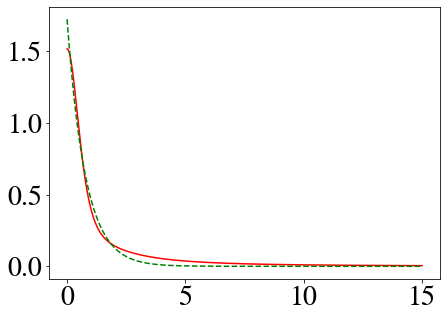

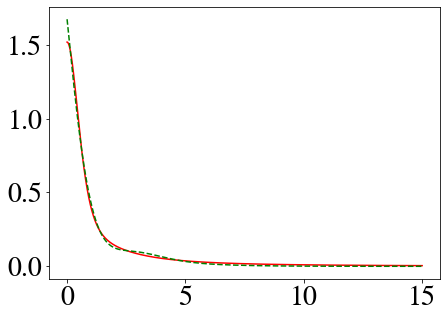

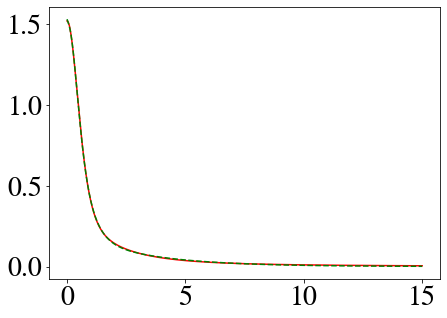

1
2
3


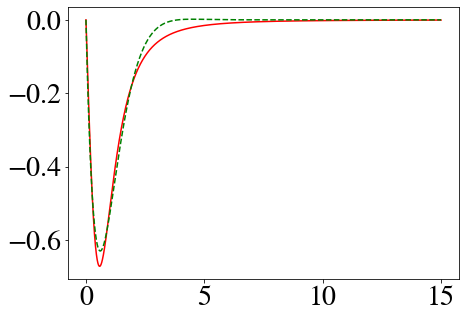

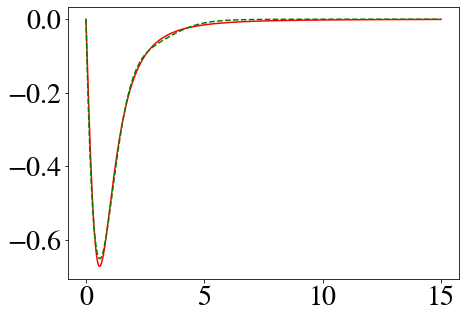

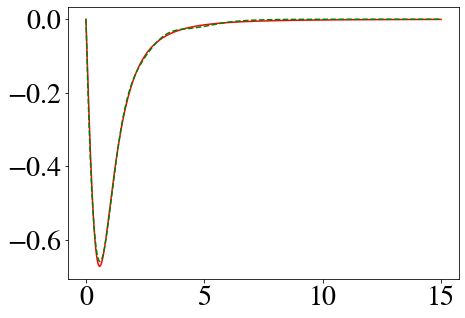

In [45]:

tlist2 = tlist3
from scipy.optimize import curve_fit

#seperate functions for plotting later:



def fit_func_nocost(x, a, b, c, N):
    tot = 0
    for i in range(N):
        # print(i)
        tot += a[i]*np.exp(b[i]*x)*np.cos(c[i]*x)
    cost = 0.
    
    return tot   

def wrapper_fit_func_nocost(x, N, *args):
    a, b, c = list(args[0][:N]), list(args[0][N:2*N]), list(args[0][2*N:3*N])
    # print("debug")
    return fit_func_nocost(x, a, b, c, N)


# function that evaluates values with fitted params at
# given inputs
def checker(tlist_local, vals, N):
    y = []
    for i in tlist_local:
        # print(i)
        
        y.append(wrapper_fit_func_nocost(i, N, vals))
    return y


#######
#Real part 

def wrapper_fit_func(x, N, *args):
    a, b, c = list(args[0][:N]), list(args[0][N:2*N]), list(args[0][2*N:3*N])
    # print("debug")
    return fit_func(x, a, b, c, N)



def fit_func(x, a, b, c, N):
    tot = 0
    for i in range(N):
        # print(i)
        tot += a[i]*np.exp(b[i]*x)*np.cos(c[i]*x )
    cost = 0.
    for i in range(N):
        #print(i)
        cost += ((corrRana[0]-a[i]))
        
        
    tot+=0.0*cost
    
    return tot      

def fitterR(ans, tlist_local, k):
    # the actual computing of fit
    popt = []
    pcov = [] 
    # tries to fit for k exponents
    for i in range(k):
        #params_0 = [0]*(2*(i+1))
        params_0 = [0.]*(3*(i+1))
        upper_a = 20*abs(max(ans, key = abs))
        #sets initial guess
        guess = []
        #aguess = [ans[0]]*(i+1)#[max(ans)]*(i+1)
        aguess = [abs(max(ans, key = abs))]*(i+1)
        bguess = [-wc]*(i+1)
        cguess = [wc]*(i+1)
        
        guess.extend(aguess)
        guess.extend(bguess)
        guess.extend(cguess) #c 
       
        # sets bounds
        # a's = anything , b's negative
        # sets lower bound
        b_lower = []
        alower = [-upper_a]*(i+1)
        blower = [-np.inf]*(i+1)
        clower = [0]*(i+1)
        
        b_lower.extend(alower)
        b_lower.extend(blower)
        b_lower.extend(clower)
        
        # sets higher bound
        b_higher = []
        ahigher = [upper_a]*(i+1)
        #bhigher = [np.inf]*(i+1)
        bhigher = [0.1]*(i+1)
        chigher = [np.inf]*(i+1)
        
        b_higher.extend(ahigher)
        b_higher.extend(bhigher)
        b_higher.extend(chigher)
      
        param_bounds = (b_lower, b_higher)
        
        p1, p2 = curve_fit(lambda x, *params_0: wrapper_fit_func(x, i+1, \
            params_0), tlist_local, ans, p0=guess, sigma=[0.1 for t in tlist_local], bounds = param_bounds, maxfev = 100000000)
        popt.append(p1)
        pcov.append(p2)
        print(i+1)
    return popt
# print(popt)



k = 3
popt1 = fitterR(corrRana, tlist2, k)
for i in range(k):
    y = checker(tlist2, popt1[i],i+1)
    plt.plot(tlist2, corrRana, tlist2, y)
    
    plt.show()
    


#y = checker(tlist3, popt1[k-1],k)
#plt.plot(tlist3, real(ctlong), tlist3, y)

#plt.show()


#######
#Imag part 



def fit_func2(x, a, b, c, N):
    tot = 0
    for i in range(N):
        # print(i)
        tot += a[i]*np.exp(b[i]*x)*np.sin(c[i]*x)
    cost = 0.
    for i in range(N):
        # print(i)
        cost += (corrIana[0]-a[i])
        
        
    tot+=0*cost
    
    return tot 
# actual fitting function


def wrapper_fit_func2(x, N, *args):
    a, b, c = list(args[0][:N]), list(args[0][N:2*N]), list(args[0][2*N:3*N])
    # print("debug")
    return fit_func2(x, a, b, c,  N)

# function that evaluates values with fitted params at
# given inputs
def checker2(tlist_local, vals, N):
    y = []
    for i in tlist_local:
        # print(i)
        
        y.append(wrapper_fit_func2(i, N, vals))
    return y

  
    
def fitterI(ans, tlist_local, k):
    # the actual computing of fit
    popt = []
    pcov = [] 
    # tries to fit for k exponents
    for i in range(k):
        #params_0 = [0]*(2*(i+1))
        params_0 = [0.]*(3*(i+1))
        upper_a = abs(max(ans, key = abs))*5
        #sets initial guess
        guess = []
        #aguess = [ans[0]]*(i+1)#[max(ans)]*(i+1)
        aguess = [-abs(max(ans, key = abs))]*(i+1)
        bguess = [-2]*(i+1)
        cguess = [1]*(i+1)
       
        guess.extend(aguess)
        guess.extend(bguess)
        guess.extend(cguess) #c 
        
        # sets bounds
        # a's = anything , b's negative
        # sets lower bound
        b_lower = []
        alower = [-upper_a]*(i+1)
        blower = [-100]*(i+1)
        clower = [0]*(i+1)
       
        b_lower.extend(alower)
        b_lower.extend(blower)
        b_lower.extend(clower)
      
        # sets higher bound
        b_higher = []
        ahigher = [upper_a]*(i+1)
        bhigher = [0.01]*(i+1)        
        chigher = [100]*(i+1)

        b_higher.extend(ahigher)
        b_higher.extend(bhigher)
        b_higher.extend(chigher)
    
        param_bounds = (b_lower, b_higher)
        
        p1, p2 = curve_fit(lambda x, *params_0: wrapper_fit_func2(x, i+1, \
            params_0), tlist_local, ans, p0=guess, sigma=[0.0001 for t in tlist_local], bounds = param_bounds, maxfev = 100000000)
        popt.append(p1)
        pcov.append(p2)
        print(i+1)
    return popt
# print(popt)

k1 = 3
popt2 = fitterI(corrIana, tlist2, k1)
for i in range(k1):
    y = checker2(tlist2, popt2[i], i+1)
    plt.plot(tlist2, corrIana, tlist2, y)
    plt.show()  
    
#tlist3 = linspace(0,1,1000)

#y = checker(tlist3, popt2[k-1],k)
#plt.plot(tlist3, imag(ctlong), tlist3, y)

#plt.show()

In [46]:
#ckAR1 = list(popt1[k-1])[:len(list(popt1[k-1]))//2]
ckAR1 = list(popt1[k-1])[:k]
#0.5 from cosine
ckAR = [0.5*x+0j for x in ckAR1]

#dress with exp(id)

#for kk in range(k):
#    ckAR[kk] = ckAR[kk]*exp(1.0j*list(popt1[k-1])[3*k+kk])

ckAR.extend(conjugate(ckAR)) #just directly double


# vkAR, vkAI
vkAR1 = list(popt1[k-1])[k:2*k] #damping terms
wkAR1 = list(popt1[k-1])[2*k:3*k] #oscillating term
vkAR = [-x-1.0j*wkAR1[kk] for kk, x in enumerate(vkAR1)] #combine
vkAR.extend([-x+1.0j*wkAR1[kk] for kk, x in enumerate(vkAR1)]) #double


print(ckAR)
print(vkAR)



[(1.1220872996510396+0j), (0.11144417420665935+0j), (-0.46905467392981137+0j), (1.1220872996510396-0j), (0.11144417420665935-0j), (-0.46905467392981137-0j)]
[(2.217530645832307-4.779614659567718e-12j), (0.3424656561489059-4.945276747791026e-17j), (4.925330232276903-3.881357076238565j), (2.217530645832307+4.779614659567718e-12j), (0.3424656561489059+4.945276747791026e-17j), (4.925330232276903+3.881357076238565j)]


In [47]:
#ckAR1 = list(popt1[k-1])[:len(list(popt1[k-1]))//2]
ckAI1 = list(popt2[k1-1])[:k1]
#0.5 from cosine
ckAI = [-1.0j*0.5*x for x in ckAI1]

#dress with exp(id)

#for kk in range(k1):
#    ckAI[kk] = ckAI[kk]*exp(1.0j*list(popt2[k1-1])[3*k1+kk])

ckAI.extend(conjugate(ckAI)) #just directly double


# vkAR, vkAI
vkAI1 = list(popt2[k1-1])[k1:2*k1] #damping terms
wkAI1 = list(popt2[k1-1])[2*k1:3*k1] #oscillating term
vkAI = [-x-1.0j*wkAI1[kk] for kk, x in enumerate(vkAI1)] #combine
vkAI.extend([-x+1.0j*wkAI1[kk] for kk, x in enumerate(vkAI1)]) #double



print(ckAI)
print(vkAI)

[0.15373069078578508j, 0.4292911908375684j, 1.6797404458604763j, -0.15373069078578508j, -0.4292911908375684j, -1.6797404458604763j]
[(1.1862313309579546-2.6967214384241545j), (1.0930292978442282-1.3692247284852528j), (0.9968059948879527-0.16449050792832484j), (1.1862313309579546+2.6967214384241545j), (1.0930292978442282+1.3692247284852528j), (0.9968059948879527+0.16449050792832484j)]


In [48]:
#check the spectrum of the fit

def spectrum_matsubara_approx(w, ck, vk):
    """
    Calculates the approximate Matsubara correlation spectrum
    from ck and vk.

    Parameters
    ==========

    w: np.ndarray
        A 1D numpy array of frequencies.

    ck: float
        The coefficient of the exponential function.

    vk: float
        The frequency of the exponential function.
    """
    return ck*2*(vk)/(w**2 + vk**2)

def spectrum_approx(w, ck,vk):
    """
    Calculates the approximate non Matsubara correlation spectrum
    from the bath parameters.

    Parameters
    ==========
    w: np.ndarray
        A 1D numpy array of frequencies.

    coup_strength: float
        The coupling strength parameter.

    bath_broad: float
        A parameter characterizing the FWHM of the spectral density, i.e.,
        the bath broadening.

    bath_freq: float
        The bath frequency.
    """
    sw = []
    for kk,ckk in enumerate(ck):
        
        #sw.append((ckk*(real(vk[kk]))/((w-imag(vk[kk]))**2+(real(vk[kk])**2))))
        sw.append((ckk*(real(vk[kk]))/((w-imag(vk[kk]))**2+(real(vk[kk])**2))))
    return sw



12


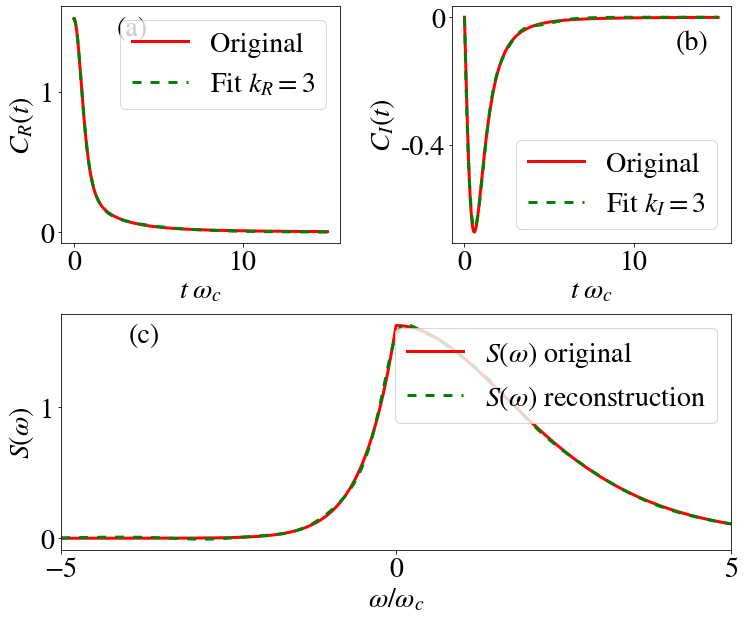

In [67]:

from cycler import cycler


wlist2 = np.linspace(-7,7 , 50000)



s1 =  [w * alpha * e**(-abs(w)/wc) *  ((1/(e**(w/T)-1))+1) for w in wlist2]
s2 =  spectrum_approx(wlist2,ckAR,vkAR)
s2.extend(spectrum_approx(wlist2,[1.0j*ckk for ckk in ckAI],vkAI))

#s2 =  spectrum_approx(wlist2,ckAI,vkAI)
print(len(s2))
s2sum = [0. for w in wlist2]
for s22 in s2:
    for kk,ww in enumerate(wlist2):
        s2sum[kk] += s22[kk]


fig = plt.figure(figsize=(12,10))
grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.3)

default_cycler = (cycler(color=['r', 'g', 'b', 'y','c','m','k']) +
                  cycler(linestyle=['-', '--', ':', '-.',(0, (1, 10)), (0, (5, 10)),(0, (3, 10, 1, 10))]))
plt.rc('axes',prop_cycle=default_cycler )

axes1 = fig.add_subplot(grid[0,0])
axes1.set_yticks([0.,1.])
axes1.set_yticklabels([0,1]) 

y = checker(tlist2, popt1[2], 3)
axes1.plot(tlist2, corrRana,'r',linewidth=3,label="Original")
axes1.plot(tlist2, y,'g',dashes=[3,3],linewidth=3,label="Fit $k_R = 3$")
axes1.legend(loc=0)

axes1.set_ylabel(r'$C_R(t)$',fontsize=28)

axes1.set_xlabel(r'$t\;\omega_c$',fontsize=28)
axes1.locator_params(axis='y', nbins=3)
axes1.locator_params(axis='x', nbins=3)
axes1.text(2.5,1.4,"(a)",fontsize=28)

axes2 = fig.add_subplot(grid[0,1])
y = checker2(tlist2, popt2[2], 3)
axes2.plot(tlist2, corrIana,'r',linewidth=3,label="Original")
axes2.plot(tlist2, y,'g',dashes=[3,3],linewidth=3,label="Fit $k_I = 3$")
axes2.legend(loc=0)
axes2.set_yticks([0.,-0.4])
axes2.set_yticklabels([0,-0.4]) 

axes2.set_ylabel(r'$C_I(t)$',fontsize=28)

axes2.set_xlabel(r'$t\;\omega_c$',fontsize=28)
axes2.locator_params(axis='y', nbins=3)
axes2.locator_params(axis='x', nbins=3)
axes2.text(12.5,-0.1,"(b)",fontsize=28)


axes3 = fig.add_subplot(grid[1,0:])
axes3.plot(wlist2, s1,  'r',linewidth=3,label="$S(\omega)$ original")
axes3.plot(wlist2, real(s2sum),  'g',dashes=[3,3],linewidth=3, label="$S(\omega)$ reconstruction")

axes3.set_yticks([0.,1.])
axes3.set_yticklabels([0,1]) 

axes3.set_xlim(-5,5)

axes3.set_ylabel(r'$S(\omega)$',fontsize=28)

axes3.set_xlabel(r'$\omega/\omega_c$',fontsize=28)
axes3.locator_params(axis='y', nbins=3)
axes3.locator_params(axis='x', nbins=3)
axes3.legend(loc=1)
axes3.text(-4,1.5,"(c)",fontsize=28)

fig.savefig("figFitCspec.pdf")


In [180]:

Q2 = []

NR = len(ckAR)
NI = len(ckAI)

Q2.extend([ sigmaz() for kk in range(NR)])
Q2.extend([ sigmaz() for kk in range(NI)])
options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)

In [182]:


NC = 11

#Q2 = [Q for kk in range(NR+NI)]
#print(Q2)
options = Options(nsteps=1500, store_states=True, rtol=1e-12, atol=1e-12, method="bdf") 
import time

start = time.time()

#HEOMFit = BosonicHEOMSolver(Hsys, Q2, ckAR2, ckAI2, vkAR2, vkAI2, NC, options=options)
HEOMFitC = BosonicHEOMSolver(Hsys, Q2, ckAR, ckAI, vkAR, vkAI, NC, options=options)
print("hello")
end = time.time()
print(end - start)

hello
470.1895263195038


In [185]:

tlist4 = np.linspace(0, 30*pi/Del, 600)
rho0 = basis(2,0) * basis(2,0).dag()   


import time

start = time.time()
resultFit = HEOMFitC.run(rho0, tlist4)
print("hello")
end = time.time()
print(end - start)

KeyboardInterrupt: 

In [186]:
# Define some operators with which we will measure the system
# 1,1 element of density matrix - corresonding to groundstate
P11p=basis(2,0) * basis(2,0).dag()
P22p=basis(2,1) * basis(2,1).dag()
# 1,2 element of density matrix  - corresonding to coherence
P12p=basis(2,0) * basis(2,1).dag()
# Calculate expectation values in the bases
P11expC11k33L = expect(resultFit.states, P11p)
P22expC11k33L = expect(resultFit.states, P22p)
P12expC11k33L = expect(resultFit.states, P12p)


In [40]:
qsave(P11expC11k33L,'P11expC12k33L')
qsave(P11exp11K4NK1TL,'P11exp11K4NK1TL')
qsave(P11exp11K3NK1TL,'P11exp11K3NK1TL')
qsave(P11exp11K3NK2TL,'P11exp11K3NK2TL')

In [54]:
P11expC11k33L=qload('P11expC12k33L')
P11exp11K4NK1TL=qload('P11exp11K4NK1TL')
P11exp11K3NK1TL=qload('P11exp11K3NK1TL')
P11exp11K3NK2TL=qload('P11exp11K3NK2TL')

Loaded ndarray object.
Loaded ndarray object.
Loaded ndarray object.
Loaded ndarray object.


In [55]:
matplotlib.rcParams['figure.figsize'] = (7, 5)
matplotlib.rcParams['axes.titlesize'] = 25
matplotlib.rcParams['axes.labelsize'] = 30
matplotlib.rcParams['xtick.labelsize'] = 28
matplotlib.rcParams['ytick.labelsize'] = 28
matplotlib.rcParams['legend.fontsize'] = 28
matplotlib.rcParams['axes.grid'] = False
matplotlib.rcParams['savefig.bbox'] = 'tight'
matplotlib.rcParams['lines.markersize'] = 5
matplotlib.rcParams['font.family'] = 'STIXgeneral' 
matplotlib.rcParams['mathtext.fontset'] =  'stix'
matplotlib.rcParams["font.serif"] = "STIX"
matplotlib.rcParams['text.usetex'] = False

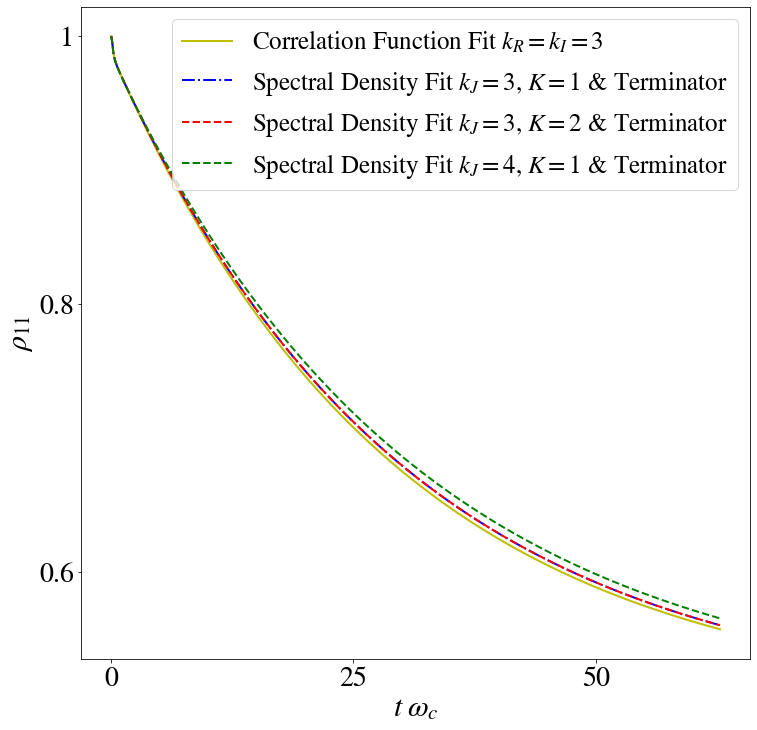

In [62]:
tlist4 = np.linspace(0, 4*pi/Del, 600)
# Plot the results
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(12,12))
axes.set_yticks([0.6,0.8,1])
axes.set_yticklabels([0.6,0.8,1]) 
axes.plot(tlist4, np.real(P11expC11k33L), 'y', linewidth=2, label="Correlation Function Fit $k_R=k_I=3$")

axes.plot(tlist4, np.real(P11exp11K3NK1TL), 'b-.', linewidth=2, label="Spectral Density Fit $k_J=3$, $K=1$ & Terminator")
axes.plot(tlist4, np.real(P11exp11K3NK2TL), 'r--', linewidth=2, label="Spectral Density Fit $k_J=3$, $K=2$ & Terminator")
axes.plot(tlist4, np.real(P11exp11K4NK1TL), 'g--', linewidth=2, label="Spectral Density Fit $k_J=4$, $K=1$ & Terminator")
axes.set_ylabel(r'$\rho_{11}$',fontsize=30)

axes.set_xlabel(r'$t\;\omega_c$',fontsize=30)
axes.locator_params(axis='y', nbins=3)
axes.locator_params(axis='x', nbins=3)
axes.legend(loc=0, fontsize=25)
fig.savefig("figFit.pdf")

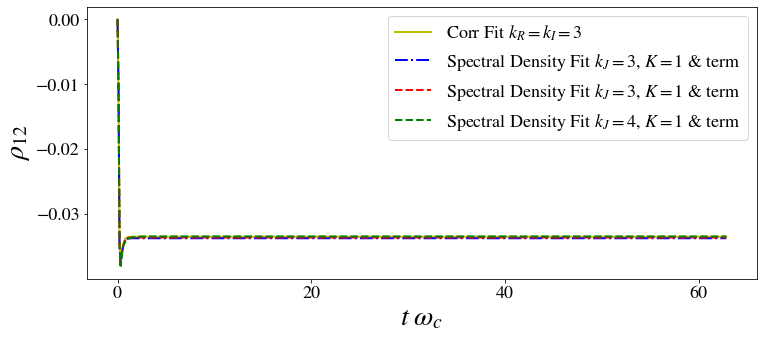

In [292]:
tlist4 = np.linspace(0, 4*pi/Del, 600)
# Plot the results
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(12,5))

axes.plot(tlist4, np.real(P12expC11k33L), 'y', linewidth=2, label="Correlation Function Fit $k_R=k_I=3$")

axes.plot(tlist4, np.real(P12exp11K3NK1TL), 'b-.', linewidth=2, label="Spectral Density Fit $k_J=3$, $K=1$ & Terminator")
axes.plot(tlist4, np.real(P12exp11K3NK2TL), 'r--', linewidth=2, label="Spectral Density Fit $k_J=3$, $K=1$ & Terminator")
axes.plot(tlist4, np.real(P12exp11K4NK1TL), 'g--', linewidth=2, label="Spectral Density Fit $k_J=4$, $K=1$ & Terminator")
axes.set_ylabel(r'$\rho_{12}$',fontsize=28)

axes.set_xlabel(r'$t\;\omega_c$',fontsize=28)
axes.locator_params(axis='y', nbins=6)
axes.locator_params(axis='x', nbins=6)
axes.legend(loc=0)


In [63]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.5.0.dev0
Numpy,1.15.4
SciPy,1.1.0
matplotlib,3.1.1
Cython,0.29.14
Number of CPUs,6
BLAS Info,INTEL MKL
IPython,7.10.2
Python,"3.7.5 (default, Oct 25 2019, 15:51:11) [GCC 7.3.0]"
OS,posix [linux]
